### Perfiles radiales de Fe/H en bines de edad

subhalo_127000000000002


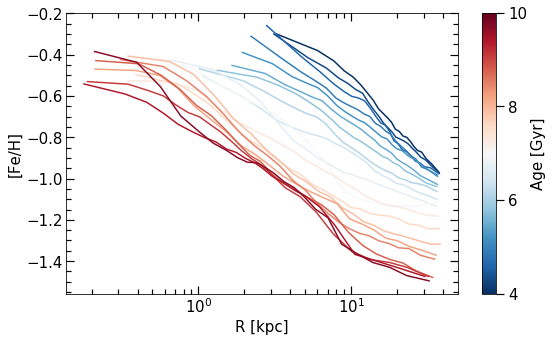

subhalo_127000000000003


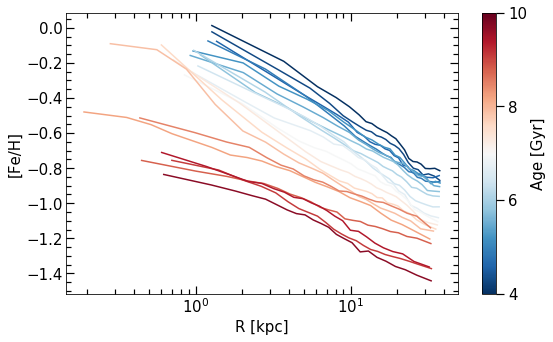

subhalo_127000000000004


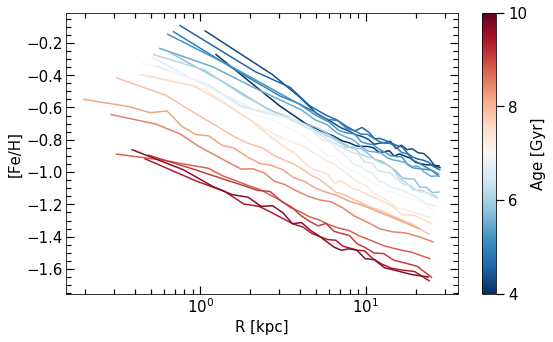

subhalo_127000000000006


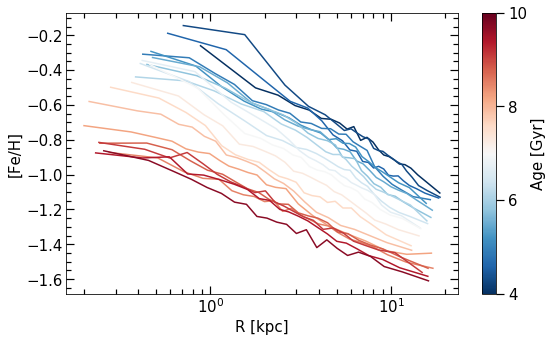

subhalo_127000000000007


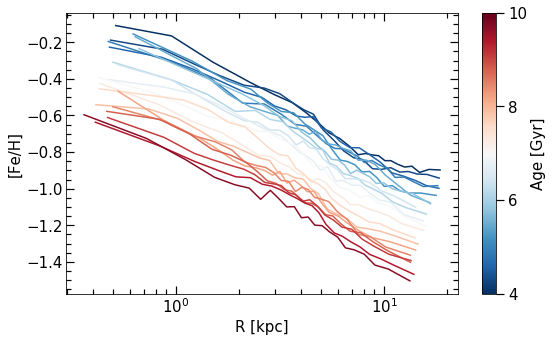

subhalo_127000000000009


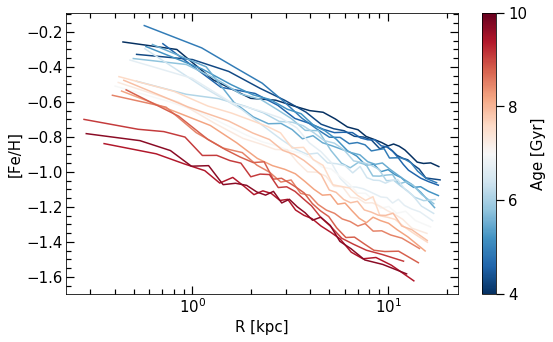

subhalo_127000000000012


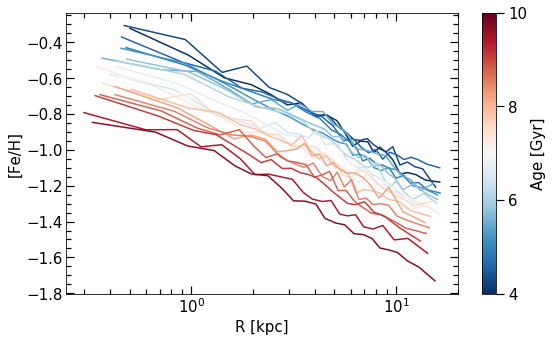

subhalo_127000000000011


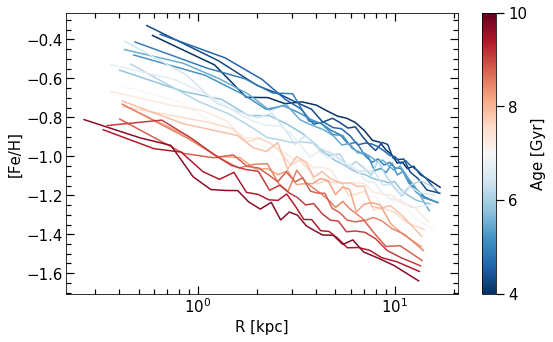

subhalo_127000000000014


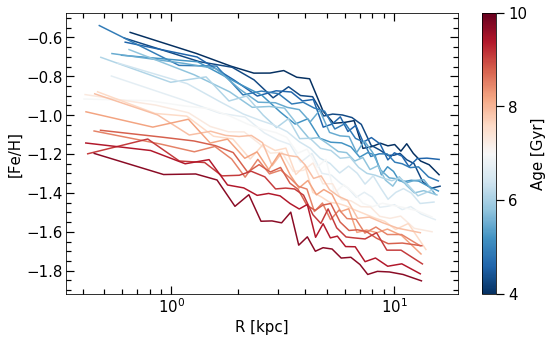

subhalo_127000000000020


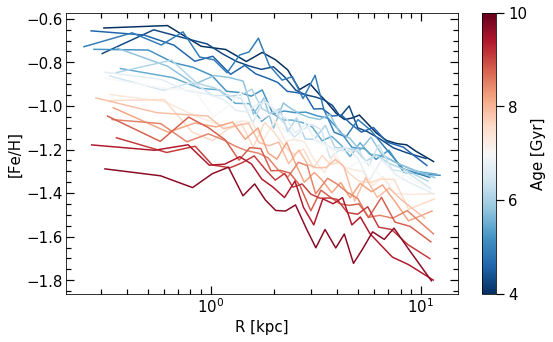

subhalo_127000000000021


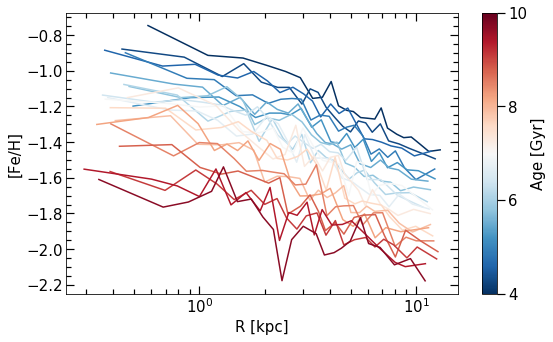

subhalo_127000000000023


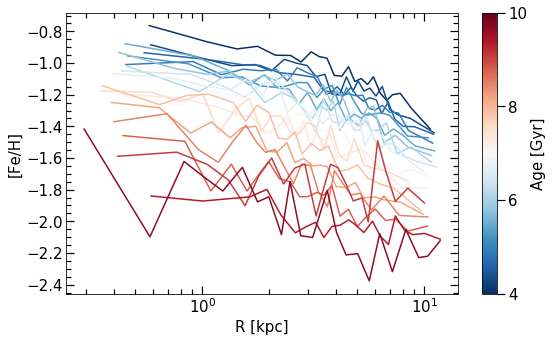

In [3]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import matplotlib as mpl
import metallicity_profile as metp

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/z/omarioni/gradients/_simulations/snap_127/'

for j in range(12):

    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[j]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]

    sft  = snap['/Str/FormationTime'][()]
    met  = snap['/Str/Metallicity'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    FeH_ = met[amask,8]/met[amask,0]
    FeH  = FeH_/0.0127

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn  = e1x*xstr + e1y*ystr + e1z*zstr
    yn  = e2x*xstr + e2y*ystr + e2z*zstr
    zn  = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    rn = np.sqrt(xn**2 + yn**2 + zn**2 )

    limit2, = np.where(rn < rgal)

    age_ = age[limit2]

    #     edades, = np.where((age_>4) & (age_<10))
    x_str = xn[limit2]
    y_str = yn[limit2]
    z_str = zn[limit2]
    FeH   = FeH[limit2]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    fig.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)


    nb = 20

    delta = (10.-4.)/nb
    rango = np.arange(4,10,delta)

    #Esto es para la barra de colores
    color_range = np.linspace(4,10,nb)
    norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap = 'RdBu_r')

    for i in rango:

        agelim = np.where((age_>i) & (age_<i+delta))

        R = np.sqrt(x_str[agelim]**2 + y_str[agelim]**2)
        z = z_str[agelim]
        FH = FeH[agelim]

        nbin = 23

        kk,  = np.where(FH>0)
#         print(len(kk))

        med, Fe_H = metp.met(R[kk],z[kk],np.log10(FH[kk]),nbin)

        ax.plot(med,Fe_H, ls='-',color = cmap.to_rgba(i))

    cbar = fig.colorbar(cmap,ticks=[4,6,8,10]) #pad=0.01)
    cbar.set_label('Age [Gyr]',fontsize=15)
    cbar.ax.tick_params( labelsize=15)
    cbar.ax.tick_params(length=8, width=1.2, which='major')

    ax.set_xscale('log')
    ax.minorticks_on()
    ax.tick_params( labelsize=15)
    ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
    ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
    # ax.set_xlim(0,14)
    ax.set_ylabel('[Fe/H]',fontsize=15)
    ax.set_xlabel('R [kpc]',fontsize=15)
    #     ax.legend(fontsize=15,frameon=False)

    plt.show()

    fig.savefig('../_imagenes/met_perfil/met_subh_'+str('%d'%ID[j])+'.png',dpi=100, xxbox_inches='tight')

### Calculo el perfil de metalicidad, z50 y densidad sup del gas

In [41]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import metallicity_profile as metp
import z50
import density

shID = np.loadtxt('../_data/my_halos.dat')[:,0]
tiempos = np.loadtxt('../_data/time.dat')
s = tiempos[:,0]

path = '/z/omarioni/gradients/_simulations/snap_'


for j in range(2,12):
    k = 0
    
    f0 = open('../_data/output_gas_met_z50_sd.txt', 'a')
    f1 = open('../_data/gas_metallicity/gas_met_prof_sh_'+str('%d'%shID[j])+'.dat', 'a')
    f2 = open('../_data/gas_z50/gas_z50_prof_sh_'+str('%d'%shID[j])+'.dat', 'a')
    f3 = open('../_data/gas_surfden/gas_surfden_prof_sh_'+str('%d'%shID[j])+'.dat', 'a')
    
    print('sh '+str('%d'%shID[j])) 
    f0.write('sh '+str('%d'%shID[j]) + '\n')
    
    for i in range(0,96):

        snap = h5py.File(path + str('%03d'%s[i])+ '/subhalo_'+str('%d'%shID[j])+'.h5py', 'r')
        
        f0.write(str('%03d'%s[i]) + '\n')
        
        if np.mod(i,10)==0:
            print(s[i])
        
        aexp = snap['/Time'][()]
        h    = snap['/h'][()]
        Om_L = snap['/Omega_Lambda'][()]
        Om_M = snap['/Omega_0'][()]
        Rvir = snap['/R200'][()]

        pstr = snap['/Str/Coordinates'][()]
        mstr = snap['/Str/Masses'][()]
        vstr = snap['/Str/Velocities'][()]
        sft  = snap['/Str/FormationTime'][()]
        
        pgas = snap['/Gas/Coordinates'][()]
        mgas = snap['/Gas/Masses'][()]
        met  = snap['/Gas/Metallicity'][()]
        

        amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
        
        if len(amask)==0:
            continue
            
        ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
        age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

        FeH_ = met[:,8]/met[:,0]
        FeH  = FeH_/0.0127

        xstr = pstr[amask,0]*aexp/h
        ystr = pstr[amask,1]*aexp/h
        zstr = pstr[amask,2]*aexp/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = pgas[:,0]*aexp/h
        ygas = pgas[:,1]*aexp/h
        zgas = pgas[:,2]*aexp/h

        v_x = vstr[amask,0] *np.sqrt(aexp)
        v_y = vstr[amask,1] *np.sqrt(aexp)
        v_z = vstr[amask,2] *np.sqrt(aexp)

        #----------------------masas----------------------------
        mstr = mstr[amask]*1e10/h
        mgas = mgas*1e10/h

        rgal = 0.15*Rvir*aexp/h
        limit, = np.where(rstr < rgal)
        
        if len(limit)==1 or len(limit)==0:
            continue
            
        rsort = np.argsort(rstr[limit])
        Mc = np.cumsum(mstr[limit][rsort])
        Mgal = Mc[-1]
        limit50, = np.where(Mc < Mgal/2)
        
        if len(limit50)==1 or len(limit50)==0:
            continue
            
        r50 = rstr[limit][rsort][limit50][-1]
        
        veloc, = np.where(rstr < r50/2.)
        
        if len(veloc)==0:
            continue

        #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

        xn_gas = e1x*xgas + e1y*ygas + e1z*zgas
        yn_gas = e2x*xgas + e2y*ygas + e2z*zgas
        zn_gas = e3x*xgas + e3y*ygas + e3z*zgas
        rn_gas = np.sqrt(xn_gas**2+yn_gas**2+zn_gas**2)


        limit2, = np.where(rn_gas < rgal)
        
        if len(limit2)==1 or len(limit2)==0:
            continue

        R = np.sqrt(xn_gas[limit2]**2 + yn_gas[limit2]**2)
        z = zn_gas[limit2]
        Fe_H = FeH[limit2]
        
        nbin = 25

        kk,  = np.where(Fe_H>0)
        
        med_FH, Fe_H = metp.met(R[kk],z[kk],np.log10(Fe_H[kk]),nbin)
        med_z,  z_50 = z50.HMSH(R[kk],z[kk],mgas[limit2][kk],nbin)
        den = density.surf_density(R[kk],mgas[limit2][kk],nbin)
        
        aux_ = np.zeros(nbin)
        aux = aux_ + s[i]
        
        mett = np.ndarray([nbin, 3])
        mett[:,0] = med_FH
        mett[:,1] = Fe_H
        mett[:,2] = aux
        
        np.savetxt(f1, mett, fmt=('%12.8f','%12.8f', '%d'))
        
        z50p = np.ndarray([nbin,3])
        z50p[:,0] = med_z
        z50p[:,1] = z_50
        z50p[:,2] = aux
        
        np.savetxt(f2, z50p, fmt=('%12.8f','%12.8f', '%d'))
        
        SDP = np.ndarray([nbin,3])
        SDP[:,0] = den[1]
        SDP[:,1] = den[0] # this is the density
        SDP[:,2] = aux
        
        np.savetxt(f3, SDP, fmt=('%12.8f','%12.8f', '%d'))
        
    f0.close()
    f1.close()
    f2.close()
    f3.close()


sh 127000000000004
127.0
117.0
107.0
97.0
87.0
77.0
67.0
57.0
47.0
37.0
sh 127000000000006
127.0
117.0
107.0
97.0
87.0
77.0
67.0
57.0
47.0
37.0
sh 127000000000007
127.0
117.0
107.0
97.0
87.0
77.0
67.0
57.0
47.0
37.0
sh 127000000000009
127.0
117.0
107.0
97.0
87.0
77.0
67.0
57.0
47.0
37.0
sh 127000000000012
127.0
117.0
107.0
97.0
87.0
77.0
67.0
57.0
47.0
37.0
sh 127000000000011
127.0
117.0
107.0
97.0
87.0
77.0
67.0
57.0
47.0
37.0
sh 127000000000014
127.0
117.0
107.0
97.0
87.0
77.0
67.0
57.0
47.0
37.0
sh 127000000000020
127.0
117.0
107.0
97.0
87.0
77.0
67.0
57.0
47.0
37.0
sh 127000000000021
127.0
117.0
107.0
97.0
87.0
77.0
67.0
57.0
47.0
37.0
sh 127000000000023
127.0
117.0
107.0
97.0
87.0
77.0
67.0
57.0
47.0
37.0


### Veo que snapshots caen entre 4 y 10 Gyr

In [47]:
import numpy as np

data = np.loadtxt('../_data/time.dat')
snap = data[:,0]
T = data[:,3]

ages = np.array([0,4,7,10])
time = 13.68449532 - ages

mask,  = np.where((T >= 4) & (T <=10))

print(T[mask])
print(snap[mask])
print(len(snap[mask]), np.diff(T[mask]))

[9.91144662 9.74929595 9.58888109 9.43021578 9.27331277 9.11818385
 8.9648398  8.81329039 8.61403112 8.4667014  8.32119142 8.17750648
 7.98877267 7.84936083 7.66633324 7.53120452 7.35388788 7.22303948
 7.05142171 6.88304876 6.75889127 6.59616586 6.43664521 6.28030977
 6.12713747 5.97710387 5.83018232 5.65086266 5.51083499 5.37381882
 5.20673049 5.04422211 4.91746297 4.76300865 4.61291832 4.43845489
 4.29767423 4.13413574 4.00225006]
[104. 103. 102. 101. 100.  99.  98.  97.  96.  95.  94.  93.  92.  91.
  90.  89.  88.  87.  86.  85.  84.  83.  82.  81.  80.  79.  78.  77.
  76.  75.  74.  73.  72.  71.  70.  69.  68.  67.  66.]
39 [-0.16215067 -0.16041486 -0.15866531 -0.15690301 -0.15512892 -0.15334405
 -0.15154941 -0.19925927 -0.14732972 -0.14550998 -0.14368494 -0.18873381
 -0.13941184 -0.18302759 -0.13512872 -0.17731664 -0.1308484  -0.17161777
 -0.16837295 -0.12415749 -0.16272541 -0.15952065 -0.15633544 -0.1531723
 -0.1500336  -0.14692155 -0.17931966 -0.14002767 -0.13701617 -0.167088

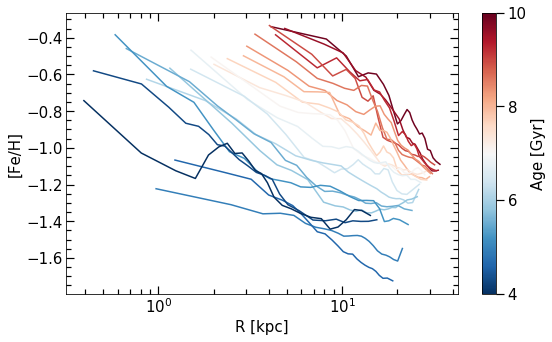

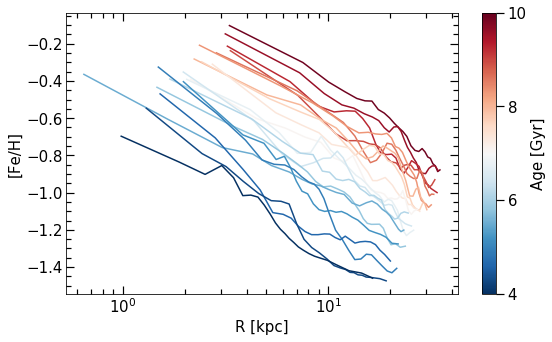

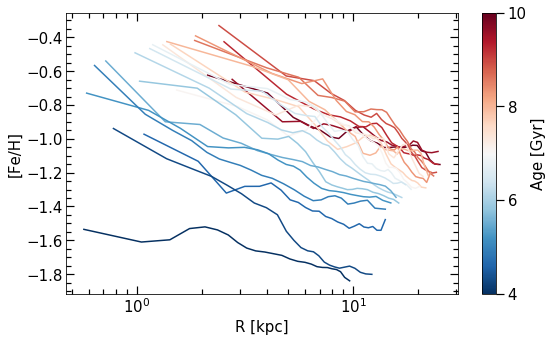

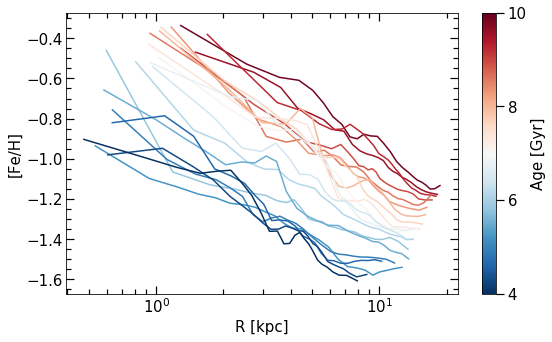

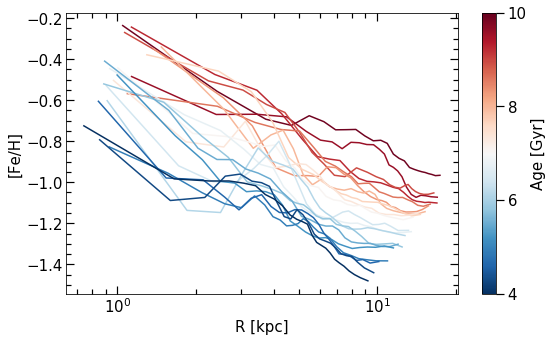

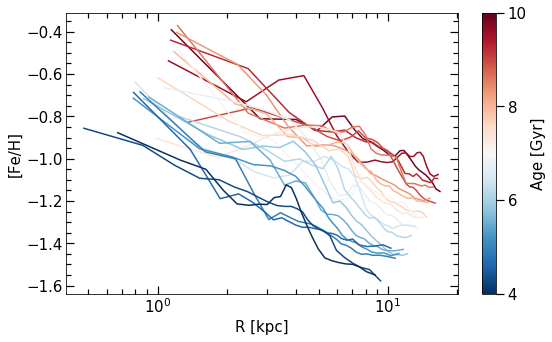

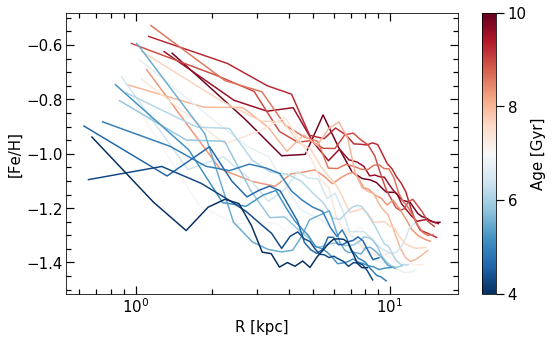

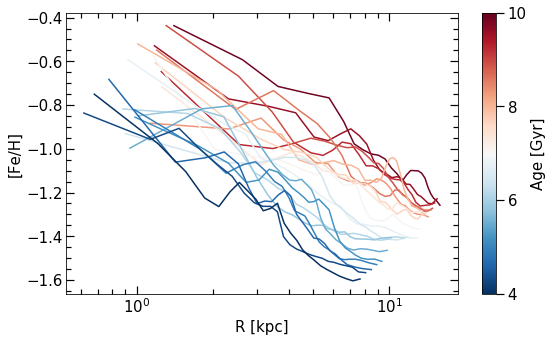

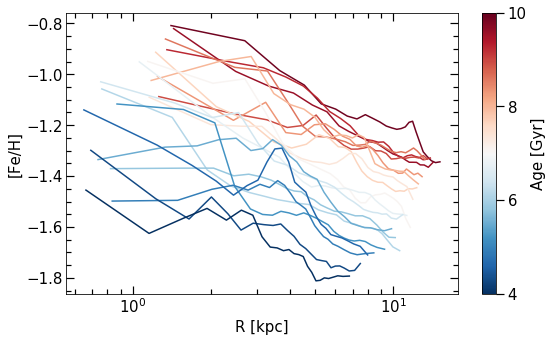

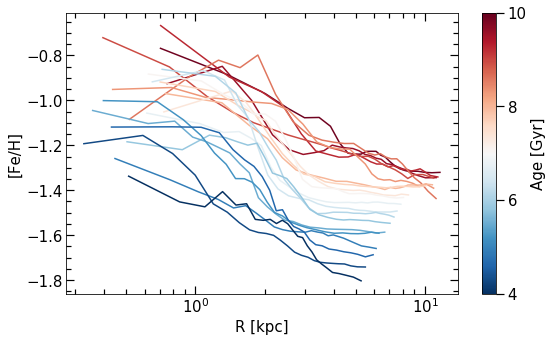

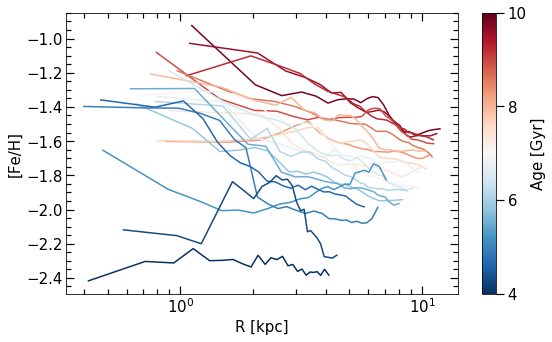

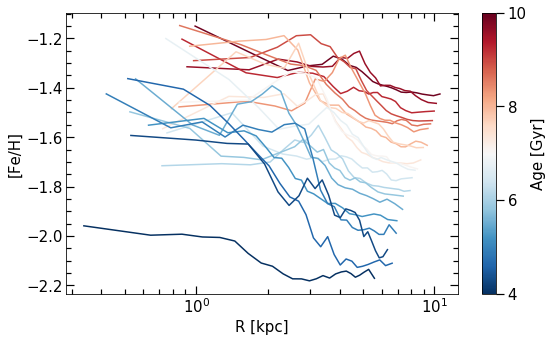

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

shID = np.loadtxt('../_data/my_halos.dat')[:,0]
data = np.loadtxt('../_data/time.dat')
s = data[:,0]
T = data[:,3]

mask,  = np.where((T >= 4) & (T <=10))

for j in range(12):
    
    mett = np.loadtxt('../_data/gas_metallicity/gas_met_prof_sh_'+str('%d'%shID[j])+'.dat')
    med = mett[:,0]
    FeH = mett[:,1]
    snap = mett[:,2]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    fig.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)

    rango = np.arange(0,len(s[mask]),2)

    #Esto es para la barra de colores
    color_range = np.linspace(4,10,len(rango))
    norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap = 'RdBu_r')

    for i in rango:
        select, = np.where(snap == s[mask][i])
        ax.plot(med[select],FeH[select], ls='-',color = cmap.to_rgba(T[mask][i]))

    cbar = fig.colorbar(cmap,ticks=[4,6,8,10]) #pad=0.01)
    cbar.set_label('Age [Gyr]',fontsize=15)
    cbar.ax.tick_params( labelsize=15)
    cbar.ax.tick_params(length=8, width=1.2, which='major')

    ax.set_xscale('log')
    ax.minorticks_on()
    ax.tick_params( labelsize=15)
    ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
    ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
    # ax.set_xlim(0,14)
    ax.set_ylabel('[Fe/H]',fontsize=15)
    ax.set_xlabel('R [kpc]',fontsize=15)
    #     ax.legend(fontsize=15,frameon=False)

    plt.show()

    fig.savefig('../_imagenes/met_perfil_gas/met_gas_sh_'+str('%d'%shID[j])+'.png',dpi=100, xxbox_inches='tight')